In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [2]:
import os
import sys

sys.path.append(os.path.abspath("../Scripts"))

In [4]:
from movie_rating import load_data, missing_value_heatmap, missing_value_bar

### Load and Explore the Data

In [5]:
#Load the Movie rating prediction dataset
df = load_data()

In [6]:
df.head(5)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [5]:
df.shape

(15509, 10)

In [ ]:
#Get info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [ ]:
#Stastical summary of numrical variable
df.describe()

,Rating
count,7919.000000
mean,5.841621
std,1.381777
min,1.100000
25%,4.900000
50%,6.000000
75%,6.800000
max,10.000000


### Handle Missing Value

#### Analysis missing value

In [7]:
#Check missing values
df.isnull().sum()

Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

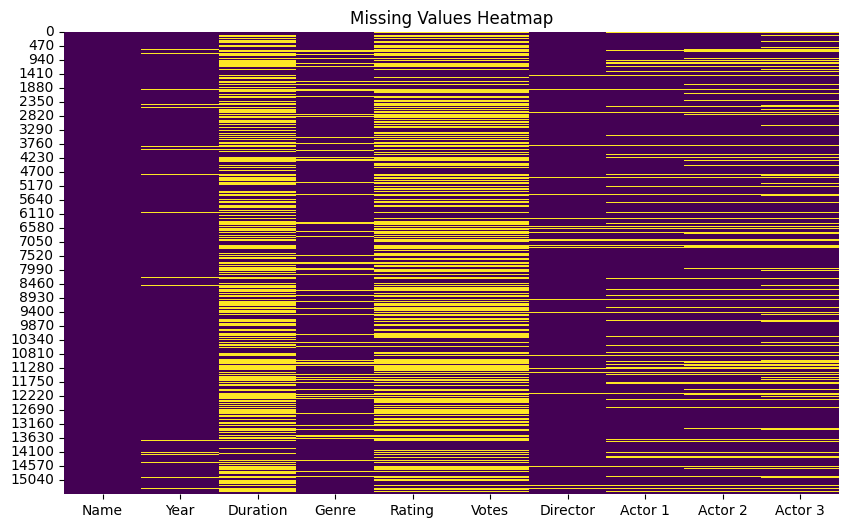

In [9]:
missing_value_heatmap(df)

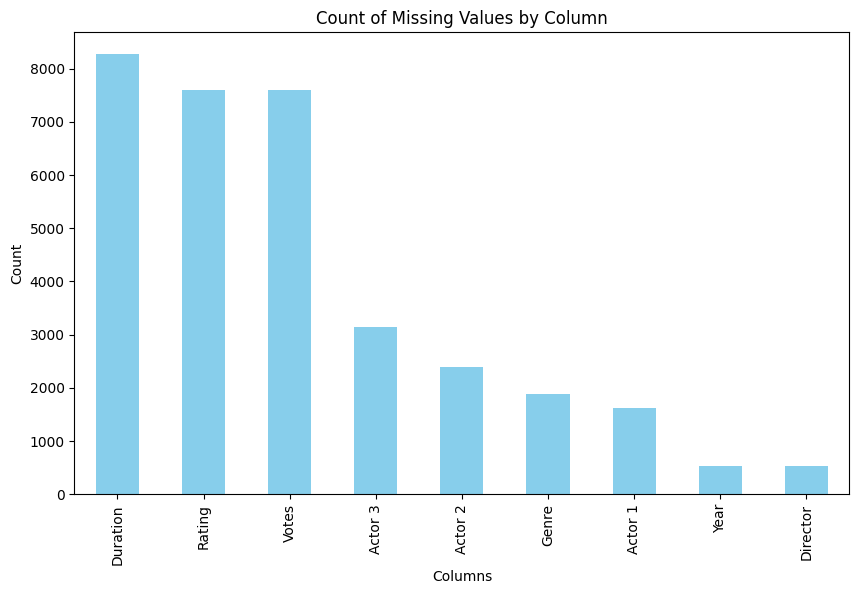

In [10]:
# Bar plot for missing values
missing_value_bar(df)
# missing_values = df.isnull().sum()
# missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
# missing_values.plot(kind='bar', figsize=(10, 6), color='skyblue')
# plt.title('Count of Missing Values by Column')
# plt.ylabel('Count')
# plt.xlabel('Columns')
# plt.show()

In [19]:
df['Duration'] = pd.to_numeric(df['Duration'],errors='coerce')
df['Duration'].fillna(df['Duration'].median(),inplace=True)

df['Votes'] = pd.to_numeric(df['Votes'],errors='coerce')
df['Votes'].fillna(df['Votes'].median(),inplace=True)

categorical_columns = ['Genre','Director','Actor 1','Actor 2','Actor 3']
for col in categorical_columns:
    df[col].fillna("Unknown",inplace=True)

# Drop rows where 'Rating' is missing as it's the target variable
df = df[df['Rating'].notna()]

#### Distribution of Target Variable (Rating)

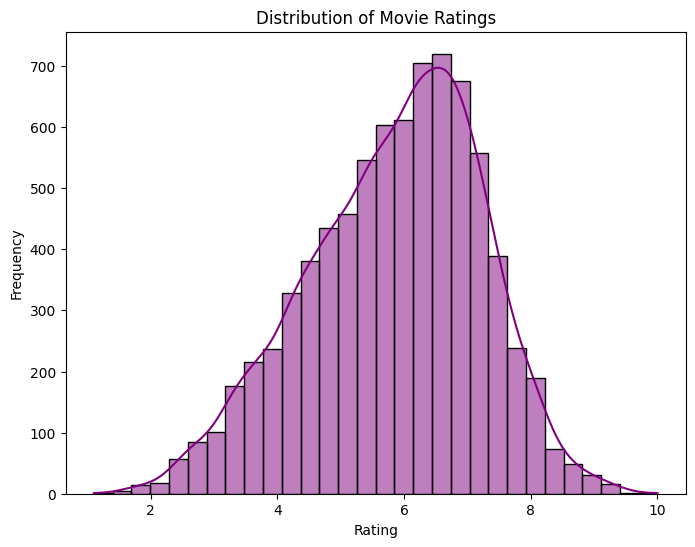

In [18]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Rating'], kde=True, color='purple', bins=30)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

### Analyze Numerical Features

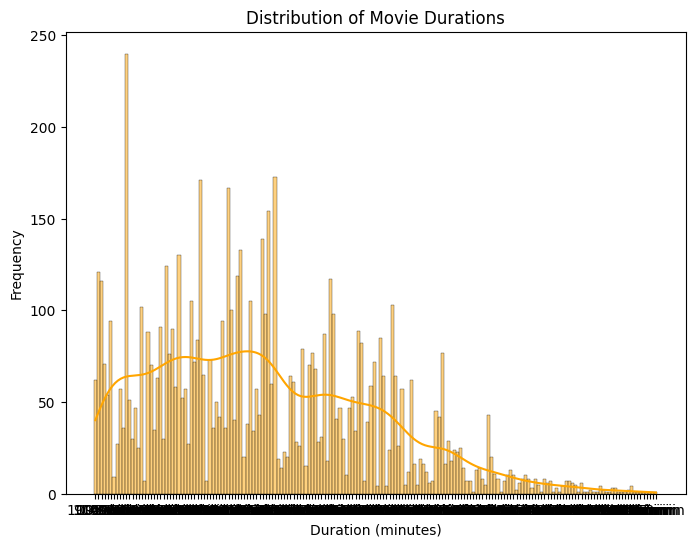

In [32]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Duration'], kde=True, color='orange', bins=30)
plt.title('Distribution of Movie Durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

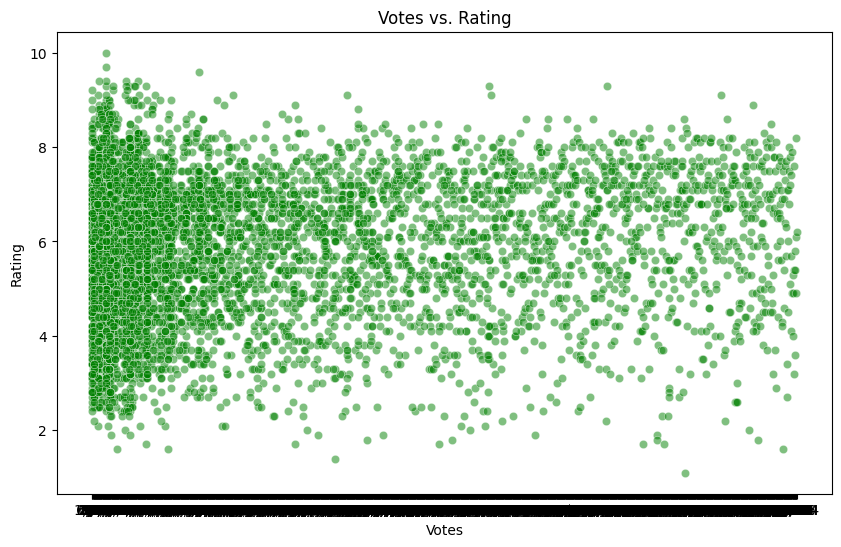

In [40]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Votes'], y=df['Rating'], alpha=0.5, color='green')
plt.title('Votes vs. Rating')
plt.xlabel('Votes')
plt.ylabel('Rating')
plt.show()

#### Analyze Categorical Features

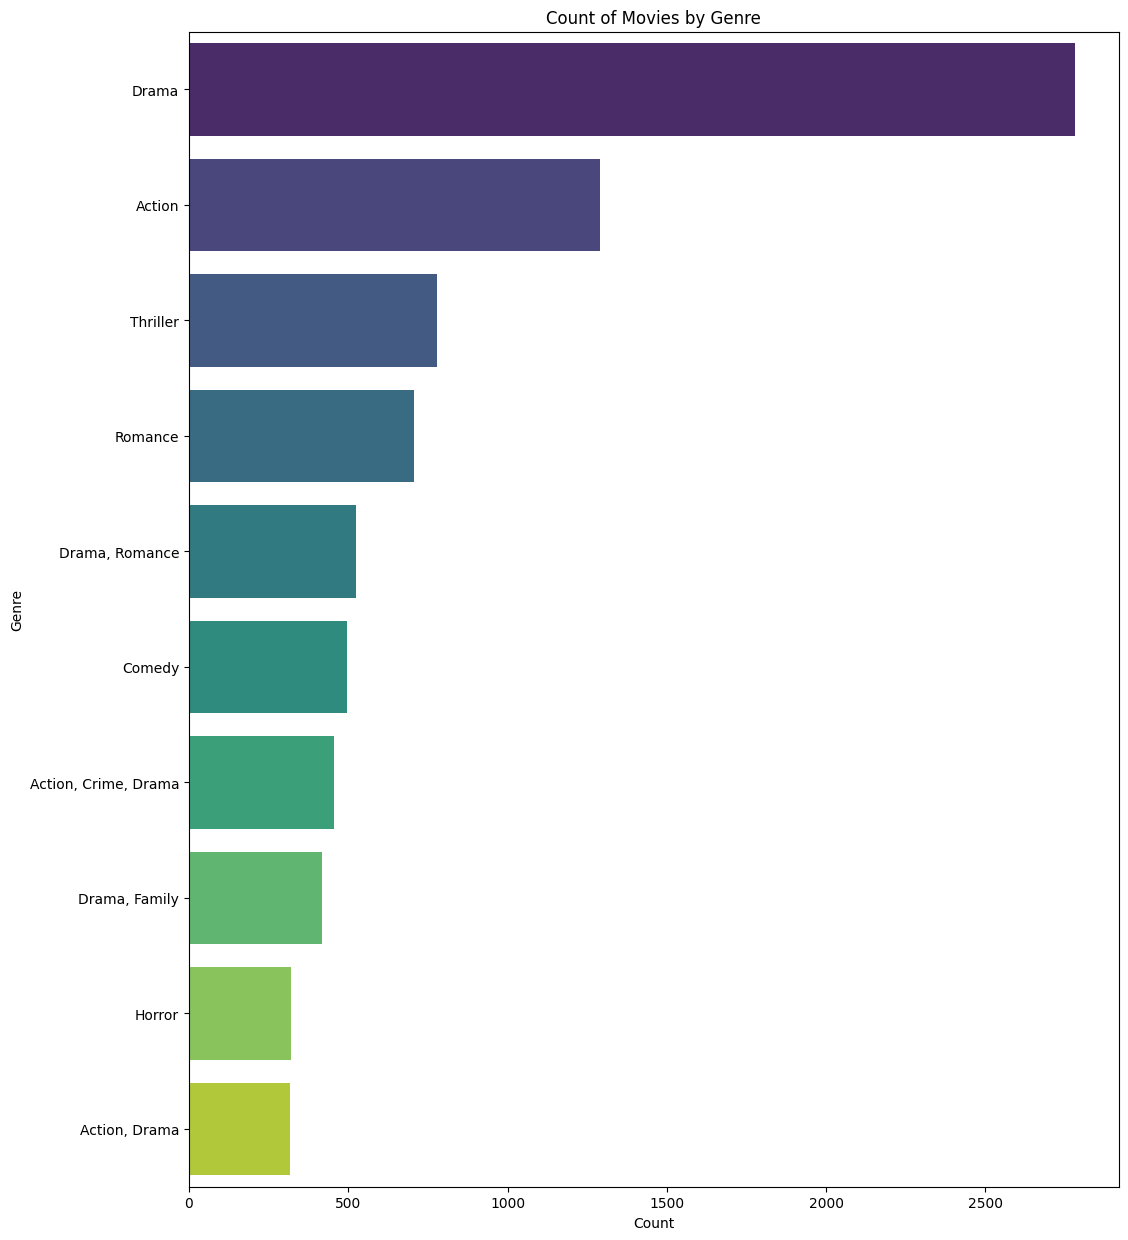

In [52]:
plt.figure(figsize=(12, 15))
top_Genre = df['Genre'].value_counts().head(10)
sns.countplot(y=df['Genre'], order=top_Genre.index, palette='viridis')
plt.title('Count of Movies by Genre')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

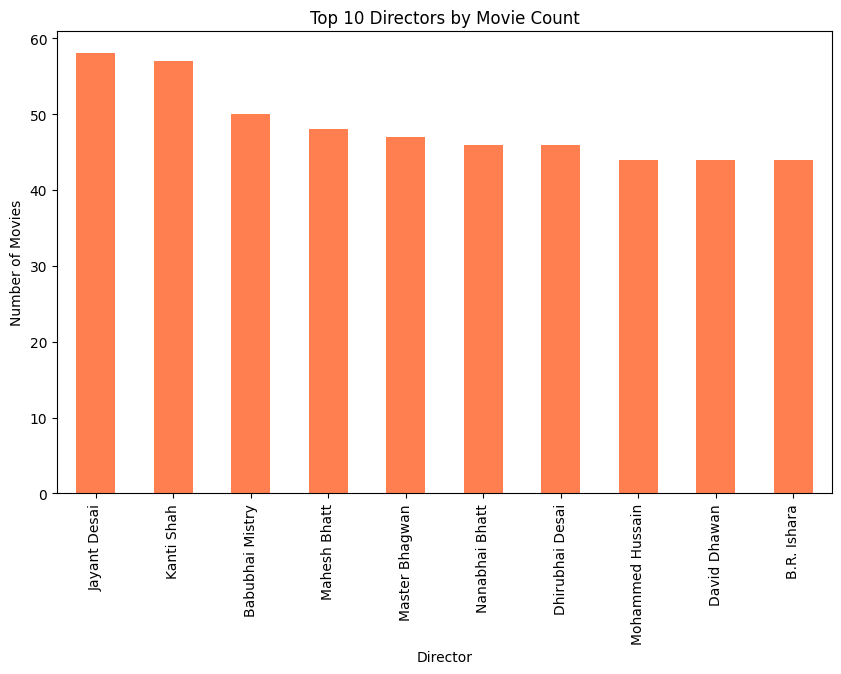

In [49]:
top_directors = df['Director'].value_counts().head(10)
top_directors.plot(kind='bar', figsize=(10, 6), color='coral')
plt.title('Top 10 Directors by Movie Count')
plt.xlabel('Director')
plt.ylabel('Number of Movies')
plt.show()

### Encode Categorical Variables

In [24]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in ['Genre','Director','Actor 1','Actor 2','Actor 3']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

### Feature Engineering

```Actor Popularity: A sum of encoded values for actors.```<br>
```Director Popularity: Based on aggregated ratings for each director.```

In [25]:
df['Actor Popularity'] = df['Actor 1'] + df['Actor 2'] + df['Actor 3']
df['Director Popularity'] = df['Director']

#### Correlation Analysis

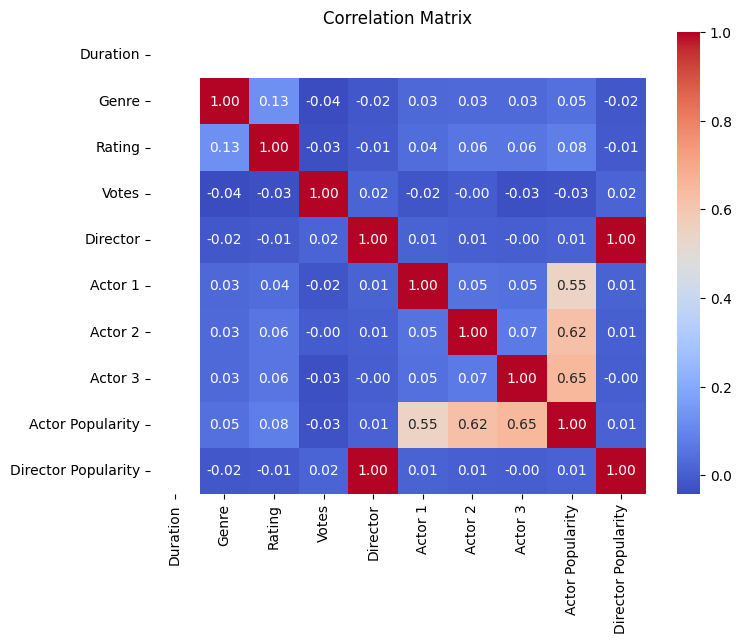

In [26]:
plt.figure(figsize=(8, 6))
correlation = df.select_dtypes(include='number').corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

#### Split Data into Train and Test Sets

In [67]:
from sklearn.model_selection import train_test_split
X = df[['Duration', 'Genre', 'Votes', 'Actor Popularity', 'Director Popularity']]
y = df['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train models

In [68]:
#Random forest Regression
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train,y_train)

#predictions
y_pred = rf_model.predict(X_test)

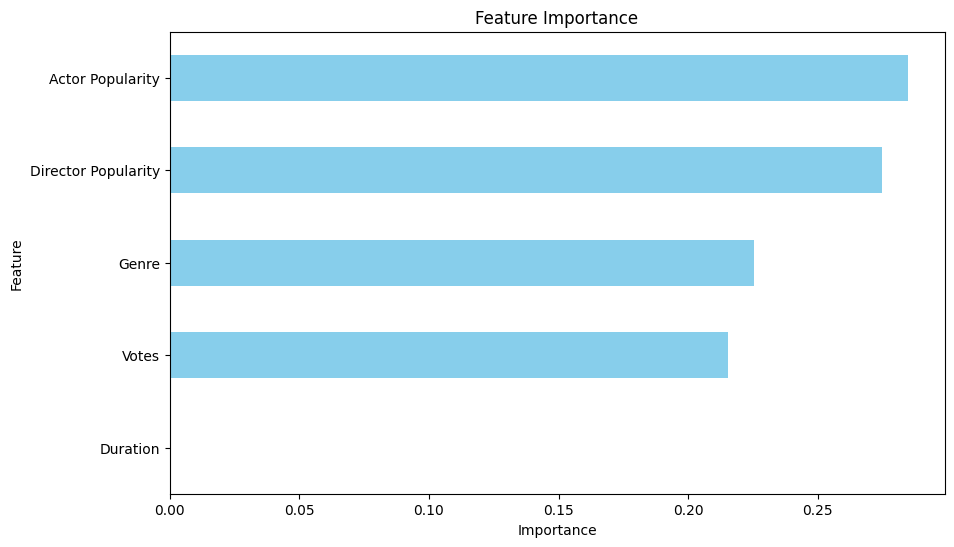

In [69]:
# Assuming rf_model is the trained RandomForestRegressor
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=True).plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

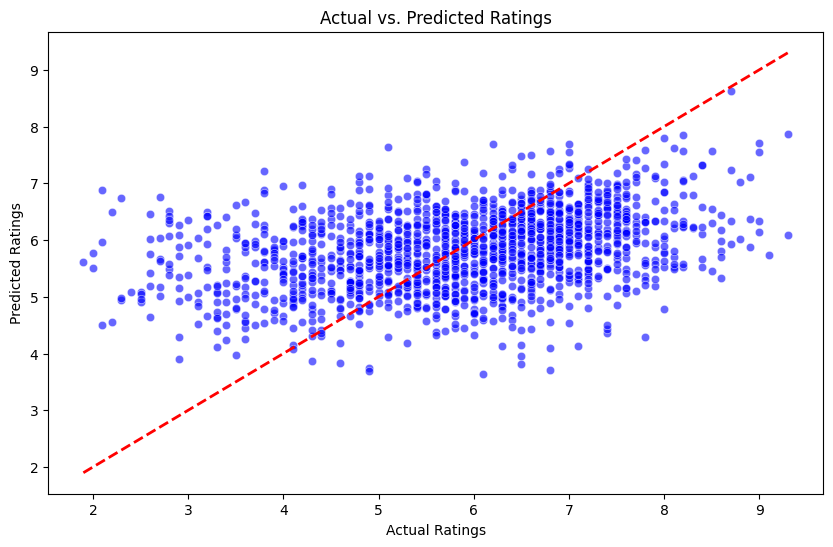

In [73]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
plt.title('Actual vs. Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.show()

In [78]:
df.groupby('Genre')['Rating'].mean().sort_values()[:100]

Genre
22     2.400000
207    2.400000
384    2.600000
66     2.700000
213    2.700000
         ...   
94     5.275000
188    5.275000
28     5.283333
52     5.289147
479    5.291667
Name: Rating, Length: 100, dtype: float64

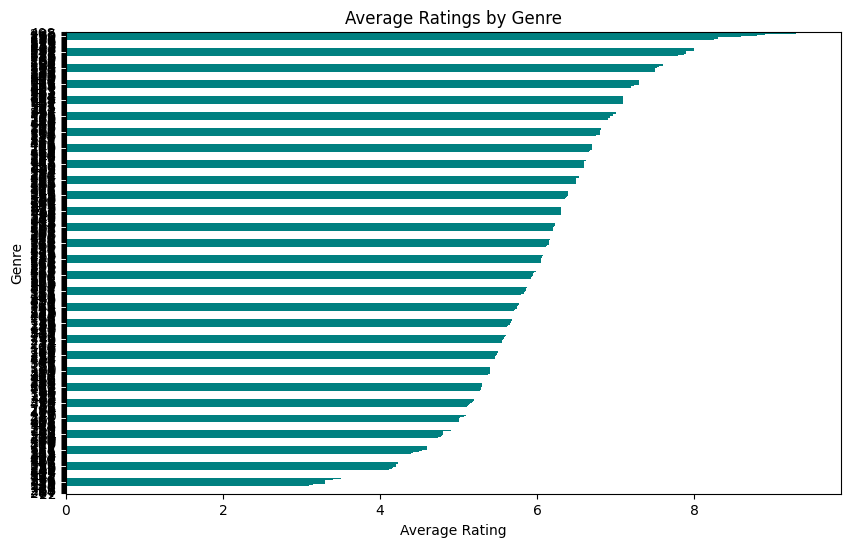

In [82]:
avg_ratings_by_genre = df.groupby('Genre')['Rating'].mean().sort_values()
avg_ratings_by_genre.plot(kind='barh', figsize=(10, 6), color='teal')
plt.title('Average Ratings by Genre')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.show()

### Evaluation the model

In [70]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
# Evaluation metrics
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R-squared (R2):", r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 1.0208985585016834
Mean Squared Error (MSE): 1.6697460266801696
Root Mean Squared Error (RMSE): 1.2921865293680204
R-squared (R2): 0.1018743022381291


### Visualize the Result

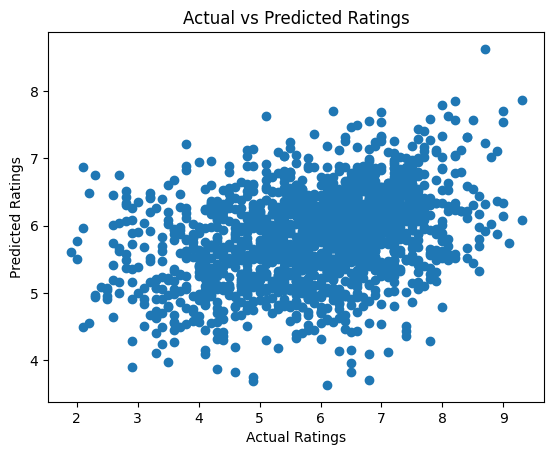

In [71]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings')
plt.show()

In [72]:
def display_predictions(y_pred):
        """Display predictions for test samples."""
        for i in range(len(y_pred)):
            print(f"X test: {X_test.iloc[i].to_dict()} | Predicted: {y_pred[i]}")

display_predictions(y_pred)

X test: {'Duration': nan, 'Genre': 460.0, 'Votes': 6.0, 'Actor Popularity': 4200.0, 'Director Popularity': 1565.0} | Predicted: 4.911999999999999
X test: {'Duration': nan, 'Genre': 16.0, 'Votes': 711.0, 'Actor Popularity': 11674.0, 'Director Popularity': 4040.0} | Predicted: 5.0280000000000005
X test: {'Duration': nan, 'Genre': 14.0, 'Votes': 35.0, 'Actor Popularity': 5858.0, 'Director Popularity': 147.0} | Predicted: 6.418000000000003
X test: {'Duration': nan, 'Genre': 299.0, 'Votes': 242.0, 'Actor Popularity': 7462.0, 'Director Popularity': 732.0} | Predicted: 6.233999999999994
X test: {'Duration': nan, 'Genre': 409.0, 'Votes': 11.0, 'Actor Popularity': 9171.0, 'Director Popularity': 5326.0} | Predicted: 3.975000000000003
X test: {'Duration': nan, 'Genre': 29.0, 'Votes': 35.0, 'Actor Popularity': 7061.0, 'Director Popularity': 5496.0} | Predicted: 6.325
X test: {'Duration': nan, 'Genre': 313.0, 'Votes': 5.0, 'Actor Popularity': 8997.0, 'Director Popularity': 5756.0} | Predicted: 5.61